In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Kaggle Dataset Link:  https://www.kaggle.com/datasets/altruistdelhite04/gold-price-data/data

# Load the Data

In [39]:
data = pd.read_csv("gold.csv")

# Data Exploration

In [40]:
data.shape

(2290, 6)

In [41]:
data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099



## Columns Description:
  -  Date - date (MM/dd/yyyy format)
  -   SPX - stands for The Standard and Poor's 500 index, or simply the S&P 500. It is a stock  market index used for tracking the stock performance of 500 of the largest companies listed on stock exchanges in USA
  -  GLD - gold price
  - USO - stands for "The United States Oil Fund ® LP (USO)". It is an exchange-traded security whose shares may be purchased and sold on the NYSE Arca
  -  SLV - silver price
  - EUR/USD - Euro to US dollar exchange ratio

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [43]:
data.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


# Missing Values

In [44]:
print("\nMissing values in the dataset:")
data.isnull().sum()


Missing values in the dataset:


Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

There are no missing values in the dataset.

### Separate Categorical and Numerical Columns

In [45]:
categoricals = data.select_dtypes(include=['object']).columns.tolist()
numericals = data.select_dtypes(include=['int64', 'float64']).columns.to_list()
categoricals, numericals

(['Date'], ['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD'])

### Drop Date Column

In [46]:
data = data.drop('Date',axis=1)
data.shape

(2290, 5)

### Outliers Detection

In [47]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

### Remove Outliers

In [48]:
data = remove_outliers_iqr(data, [each for each in numericals])
data.shape

(1909, 5)

In [49]:
data.head()

,SPX,GLD,USO,SLV,EUR/USD
6,1420.329956,88.250000,74.019997,16.061001,1.480100
7,1401.020020,88.580002,73.089996,16.077000,1.479006
9,1380.949951,87.989998,72.779999,15.834000,1.480210
10,1373.199951,86.699997,71.849998,15.654000,1.466405
11,1333.250000,86.500000,71.029999,15.717000,1.464000


### Split Data into Features and Target

In [50]:
X = data.drop(columns=['GLD']) # All columns except Target column
y = data['GLD'] # Target column
numericals.remove('GLD')

### Train Test Split

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize Numerical Features

In [52]:
scaler = StandardScaler()
X_train[numericals] = scaler.fit_transform(X_train[numericals])
X_test[numericals]  = scaler.transform(X_test[numericals])

# Model Building

### Decision Tree Regressor

In [53]:
dt_model = DecisionTreeRegressor(max_depth=5, random_state=62)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

### Random Forest Regressor

In [54]:
rf_model = RandomForestRegressor(n_estimators=250, max_depth=5, random_state=33)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

### Support Vector Machine Regressor

In [55]:
svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Evaluate Models

In [56]:
def evaluate_model(name, y_test, y_pred):

    mse = mean_squared_error(y_test, y_pred)

    mae = mean_absolute_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)

    print(f"{name} Performance:")

    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}\n")




In [57]:
evaluate_model("Decision Tree", y_test, dt_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("SVM", y_test, svm_pred)

Decision Tree Performance:
MSE: 24.4408, MAE: 3.6255, R²: 0.9332

Random Forest Performance:
MSE: 16.2949, MAE: 3.1036, R²: 0.9554

SVM Performance:
MSE: 17.4821, MAE: 2.3646, R²: 0.9522



# Visualize Predictions

In [58]:
sorted_idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[sorted_idx]
dt_pred_sorted = dt_pred[sorted_idx]
rf_pred_sorted = rf_pred[sorted_idx]
svm_pred_sorted = svm_pred[sorted_idx]

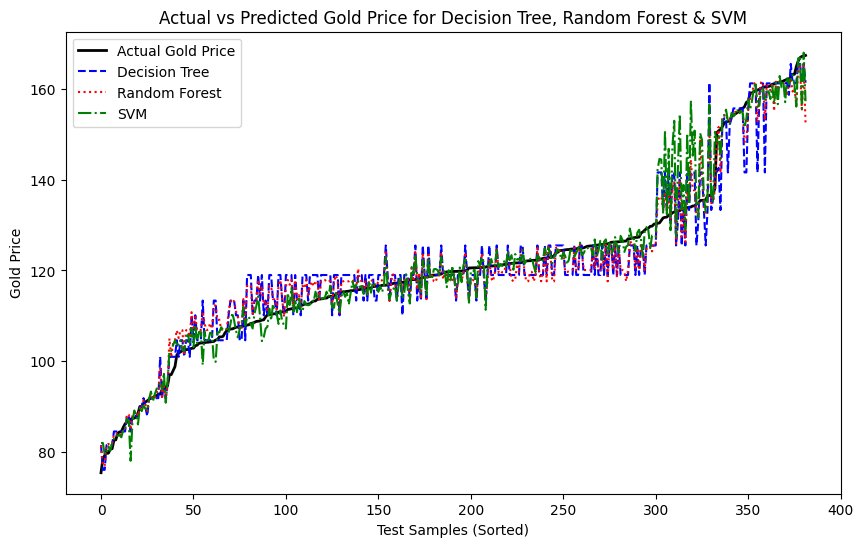

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted, label="Actual Gold Price", color="black", linestyle="-", linewidth=2)
plt.plot(dt_pred_sorted, label="Decision Tree", color="blue", linestyle="--")
plt.plot(rf_pred_sorted, label="Random Forest", color="red", linestyle=":")
plt.plot(svm_pred_sorted, label="SVM", color="green", linestyle="-." )
plt.xlabel("Test Samples (Sorted)")
plt.ylabel("Gold Price")
plt.title("Actual vs Predicted Gold Price for Decision Tree, Random Forest & SVM")
plt.legend()
plt.show()


# Conclusion:
- SVM provides the best overall performance, as it follows the actual price with the least fluctuation.
- Decision Tree struggles with overfitting, making it unreliable for stable predictions.
- Random Forest balances stability and flexibility, making it a strong contender.